In [10]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import requests
import re
import itertools
import time
import json
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st

# Part 1: Web scraping

## 2019 Oral presentations

To scrape a site the first step is to look at the site and its source code and look for patterns

For getting the data out we use beautifulsoup which is a very comprehensive library for web scraping.

Looking at the site we notice that this website is not very suited for web scraping, it uses close to none classes and ids, which is probably the most easy way to get the data you want

Also there are a lot of mistakes in the overall layout that so we have to do a lot of tests for mistakes in the data we get out


<hr>

If we look at the page we notice an overall pattern that every presentation has a chair person that in the code had the \<em> tag

We can easily target these tags with beautifulsoup and then loop over the tags and get their parents

In [11]:

# We define the oral pres

urls = ["https://2019.ic2s2.org/oral-presentations/"]

# we get the url
url = urls[0]

soup = BeautifulSoup(requests.get(url).text, 'html.parser')

In [12]:
# we get all the chairs
chairs = soup.find_all("em")
chair_names = [str(chair.text).split(": ")[1] for chair in chairs]

In [13]:
# We get the unique chair names
unique_chairs = set(chair_names)

In [14]:
# We crate an empty set to store the unique names and add the unique chairs
total_names_oral = set()
total_names_oral = total_names_oral.union(unique_chairs)


In [15]:
# This is just here if we want to define a subset
all_chairs = chairs[:]

In [16]:
# This function takes some html code which is a chair parent and returns all the unique names in the given section, this we will loop over for all the chairs
# To simplify the code we use a bit of regular expressions for splitting and filtering

def return_names(chair_parent):
    # filter out chairs
    no_chairs = [val for val in chair_parent if "Chair" not in val]

    # remove all elements that start with digits
    no_start_digits = [val for val in no_chairs if not re.search("^\d", val) if not re.search("^(Thursday|Friday|Saturday)", val)]


    # we can see a pattern that the names and what they are presenting is separated by either a dot or -
    split_list = [re.split("\. | –", val) for val in no_start_digits]


    # This turns a 2d list into a 1d list
    split_list_flat = list(itertools.chain.from_iterable(split_list))
 
    # We filter out the entries that end in a digit and have the word presentation in them, as these are "no presentation"
    name_strings = [val for val in split_list_flat if not re.search("(\d|\(|\)|presentation)", val)]


    # We can see that some names are separated by a comma, so we split them
    names = [re.split(", |,", val) for val in name_strings if len(re.split(", |,", val)[0].split(" ")) < 5]


    names_flattened = set([name for sublist in names for name in sublist])

    return names_flattened
    



In [17]:
# This is where we loop over all the chairs
for chair in all_chairs:
    chair_parent = chair.parent.text.split(" – ")
    names = return_names(chair_parent)
    total_names_oral = total_names_oral.union(names)

    
total_names_oral_list = list(total_names_oral)
# total_names_list


## 2019 Poster presentations

The layout of this site is not the same as the other however in this case this is not bad, as the layout of this page is a lot better for scraping than the other

To scrape this page we find the main content by the class <em>col-md-8 page-content-wrap<em/> and this find all the ul's (unorded lists) with all their li's (list elements)

In [18]:
urls = ["https://2019.ic2s2.org/posters/"]

url = urls[0]

soup = BeautifulSoup(requests.get(url).text, 'html.parser')
total_names_poster = set()

In [21]:

# Get the main content div
div = soup.find("div", {"class": "col-md-8 page-content-wrap"})


# Get all the uls
uls = div.find_all("ul")


# We now loop over the two uls and get the li elements
for ul in uls:
    lis = ul.find_all("li")
    for li in lis:
        name_string = li.contents[0].text
        # WE use some regular expression to split the string
        if re.search("(\d|\(|\)|:|–)", name_string):
            # print(name_string)
            continue
        names = re.split(", |,| and ", name_string)
        # print(names)
        total_names_poster = total_names_poster.union(names)

In [22]:
# The total names is then just the union of the two sets

names_combined = total_names_oral.union(total_names_poster)
names_combined_list = list(names_combined)

print(f"length of combined list: {len(names_combined_list)}")

length of combined list: 946


# Part 2: Semantic Scholar API

## Get all Author ids

In [98]:
BASE_URL = "https://api.semanticscholar.org/graph/"
VERSION = "v1/"
RESOURCE = "author/search"

complete_url = BASE_URL + VERSION + RESOURCE

complete_url

'https://api.semanticscholar.org/graph/v1/author/search'

In [ ]:
def get_all_authorids(author_data):
    original_author = author_data["authorId"]
    author_ids = [original_author]
    print(original_author)
    for paper in author_data["papers"]:
        for author in paper["authors"]:
            author_ids.append(author["authorId"])
    return set(author_ids), original_author

In [ ]:
all_author_ids_set = set()
original_authors = []
for name in list(names_combined):
    params = {
        "query": name,
        "fields": "name,papers.authors",
    }
    time.sleep(3)
    response = requests.get(complete_url, params=params)
    response_json = response.json()
    if "data" not in response_json:
        continue
    if len(response_json["data"]) == 0:
        continue
    first_entry = response_json["data"][0]
    author_ids, original_author = get_all_authorids(first_entry)
    all_author_ids_set = all_author_ids_set.union(author_ids)
    original_authors.append(original_author)
    # print(author_ids)
    # print("\n")

In [ ]:
df = pd.DataFrame(list(all_author_ids_set))
og_df = pd.DataFrame({"author_id": list(original_authors)})

In [ ]:
df.to_csv("author_ids.csv", index=False)
og_df.to_csv("original_author_ids.csv", index=False)

In [23]:
# read in the data
# df = pd.read_csv("author_ids.csv")
# og_df = pd.read_csv("original_author_ids.csv")



## Get Author papers

We will only be using the original authors from the 2019 IC2S2 the next section, what i mean by that is that i am not using the dataset i collected with all the collarborators as well as this dataset is about 30000 authors while the original ones are about 900. The reasoning behind this is that for some reason the batch api endpoint was not working for me, so i could not get the data for the authors in batches of 1000, and therefore have to get the data from each author separately, which means i will have to 1 api call for each author, and there is a rate limit of 100 requests per 5 min, which means if i had to do it with all 30000 if would take me 1500 minutes, which is about a half day of doing api calls

In [ ]:
# read in data from csv
author_ids_df = pd.read_csv("original_author_ids.csv")
author_ids_list = author_ids_df.iloc[:,0].tolist() # we turn it into a list

In [ ]:
BASE_URL = "https://api.semanticscholar.org/graph/"
VERSION = "v1/"
RESOURCE = "author/"

complete_url = BASE_URL + VERSION + RESOURCE

complete_url

In [89]:
def get_categories(paper):
    categories = set()
    for category in paper["s2FieldsOfStudy"]:
        categories.add(category["category"])
    return categories

def get_all_categories(papers):
    categories = set()
    for paper in papers:
        for category in paper["s2FieldsOfStudy"]:
            categories.add(category["category"])
    return categories


def get_field_of_study(papers):
    categories = []
    for paper in papers:
        for category in paper["s2FieldsOfStudy"]:
            categories.append(category["category"])
    # get the most common category
    return max(set(categories), key=categories.count, default=None)

def get_paper_author_ids(paper):
    author_ids = []
    for author in paper["authors"]:
        author_ids.append(author["authorId"])
    return author_ids

# The dataframes

# Author dataframe with authorId, name, aliases, citationCount, s2FieldsOfStudy
author_df = pd.DataFrame(columns=["authorId", "name", "aliases", "citationCount", "s2FieldsOfStudy"])

# Paper dataframe with paparid, title, year, externalid, citationCount, s2FieldsOfStudy, authorids
paper_df = pd.DataFrame(columns=["paperId", "title", "year", "externalId", "citationCount", "s2FieldsOfStudy", "authorIds"])

# paper abstract dataframe with paperid, abstract
paper_abstract_df = pd.DataFrame(columns=["paperId", "abstract"])


In [90]:
for author_id in author_ids_list:
    params = {
        "fields": "name,aliases,citationCount,papers,papers.title,papers.abstract,papers.year,papers.externalIds,papers.s2FieldsOfStudy,papers.citationCount,papers.authors",
    }
    time.sleep(3)
    response = requests.get(complete_url+str(author_id), params=params)
    # print(response)
    response_json = response.json()
    # print(response_json)
    # print("\n")
    
    # Make the auther dict to be added to the author dataframe
    try:
        author_dict = {"authorId": author_id, "name": response_json["name"], "aliases": response_json["aliases"], "citationCount": response_json["citationCount"], "s2FieldsOfStudy": get_field_of_study(response_json["papers"])}

        # concat to author dataframe
        author_df = pd.concat([author_df, pd.DataFrame([author_dict])], ignore_index=True)
    except KeyError:
        continue

    # loop over all the papers
    for paper in response_json["papers"]:
        paper_dict = {"paperId": paper["paperId"], "title": paper["title"], "year": paper["year"], "externalId": paper["externalIds"]["DOI"] if "DOI" in paper["externalIds"] else None, "citationCount": paper["citationCount"], "s2FieldsOfStudy": list(get_categories(paper)), "authorIds": get_paper_author_ids(paper)}

        # Concat to paper dataframe
        paper_df = pd.concat([paper_df, pd.DataFrame([paper_dict])], ignore_index=True)

        paper_abstract_dict = {"paperId": paper["paperId"], "abstract": paper["abstract"]}

        # Concat to paper abstract dataframe
        paper_abstract_df = pd.concat([paper_abstract_df, pd.DataFrame([paper_abstract_dict])], ignore_index=True)






In [97]:
# export the 3 dataframes to csv
author_df.to_csv("author_df.csv", index=False)
paper_df.to_csv("paper_df.csv", index=False)
paper_abstract_df.to_csv("paper_abstract_df.csv", index=False)

In [40]:
# read in the data if we need to
author_df = pd.read_csv("author_df.csv")
paper_df = pd.read_csv("paper_df.csv")
paper_abstract_df = pd.read_csv("paper_abstract_df.csv")

# Part 3: Law of large numbers

## Gaussian Distribution

In [41]:
# 1
# Create random variable X with mean 0 and standard deviation 4 containing 10000 values
mu = 0
sigma = 4
N = 10000
X = np.random.normal(mu, sigma, N)

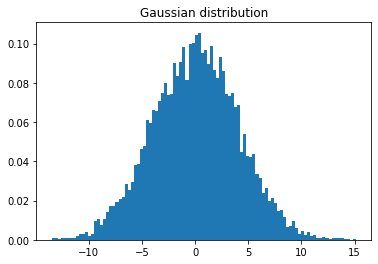

In [58]:
# 2
# We plot the distribution
plt.hist(X, bins=100, density=True)
plt.title("Gaussian distribution")
plt.show()

In [43]:
# 3
# Compute cumulative average of X
cum_avg = np.cumsum(X) / (np.arange(N) + 1)


# Cumulative average of X using pandas as this become handy when calculating the cumulative std
X_df = pd.DataFrame({"X": X})
cum_avg_df = X_df.expanding().mean()
cum_avg_df

,X
0,-3.539353
1,-4.397233
2,-4.532112
3,-2.343664
4,-2.409501
...,...
9995,0.043707
9996,0.044366
9997,0.044554
9998,0.044298


In [44]:
# 4
# Cumulative standard error of the mean (sem) of X
cum_sem = X_df.expanding().sem()
cum_sem["X"][0] = 0

In [45]:
# 5
# We can use python to calculate the mean and median of X

print("Mean of X: ", np.mean(X))
print("Median of X: ", np.median(X))

# By the law of large numbers as the size N of the sample increases the mean of the sample approaches the mean of the population which should be 0



Mean of X:  0.043993576757795826
Median of X:  0.08331707632490105


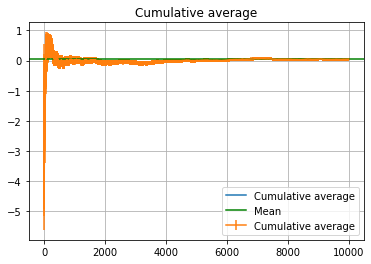

In [46]:
# 6
plt.plot(cum_avg_df, label="Cumulative average")
plt.title("Cumulative average")
plt.grid()


# errorbar with cum_sem as error bars
plt.errorbar(cum_avg_df.loc[0:10000, "X"].index, cum_avg_df.loc[0:10000, "X"], yerr=cum_sem.loc[0:10000, "X"], label="Cumulative average")

# horizontal line at mean
plt.axhline(y=np.mean(X), color="g", linestyle="-", label="Mean")

plt.legend()
plt.show()



In [47]:
# 7
# Cumulative median of X
cum_med_df = X_df.expanding().median()

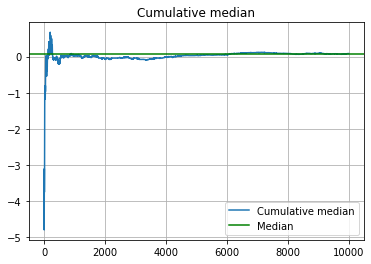

In [48]:
# 8
plt.plot(cum_med_df, label="Cumulative median")
plt.title("Cumulative median")
plt.grid()

# horizontal line at median
plt.axhline(y=np.median(X), color="g", linestyle="-", label="Median")
plt.legend()
plt.show()

In [49]:
# We create 1 function to calculate all the previous values in one go

def calculate_cumulative_stats(X):
    # Create dataframe from X
    X_df = pd.DataFrame({"X": X})


    # Histogram plot
    plt.figure(1)
    plt.hist(X, bins=100, density=True)
    plt.title("Histogram of X")
    
    plt.show()

    # Cumulative average of X
    cum_avg_df = X_df.expanding().mean()

    # Cumulative standard error of the mean (sem) of X
    cum_sem = X_df.expanding().sem()
    cum_sem["X"][0] = 0

    # Cumulative median of X
    cum_med_df = X_df.expanding().median()

    # Plots
    # Cumulative average of X
    plt.figure(2)
    plt.plot(cum_avg_df, label="Cumulative average")
    plt.title("Cumulative average")
    plt.grid()


    # errorbar with cum_sem as error bars
    plt.errorbar(cum_avg_df.loc[0:10000, "X"].index, cum_avg_df.loc[0:10000, "X"], yerr=cum_sem.loc[0:10000, "X"], label="Cumulative average")

    # horizontal line at mean
    plt.axhline(y=np.mean(X), color="g", linestyle="-", label="Mean")

    plt.legend()
    plt.show()
    

    plt.figure(3)
    # cumulative median of X
    plt.plot(cum_med_df, label="Cumulative median")
    plt.title("Cumulative median")
    plt.grid()

    # horizontal line at median
    plt.axhline(y=np.median(X), color="g", linestyle="-", label="Median")
    plt.legend()
    plt.show()

    return cum_avg_df, cum_sem, cum_med_df


## Pareto Distribution

In [50]:
xm = 1
alpha = 0.5
N = 10000


# sample from pareto distribution
P = np.random.pareto(alpha, N) + xm



In [51]:
np.mean(P)

# mean of both P and P_scipy
print("Mean of P: ", np.mean(P))


Mean of P:  3876.6348472927416


In [52]:
# mean from formula
P_mean = alpha* xm /(alpha-1)

# median from formula
P_med = xm*2**(1/alpha)

print(f"{P_mean=} - {P_med=}")
print("From distribution:")
print(f"{np.mean(P)=} - {np.median(P)=}")



P_mean=-1.0 - P_med=4.0
From distribution:
np.mean(P)=3876.6348472927416 - np.median(P)=3.892693642721163


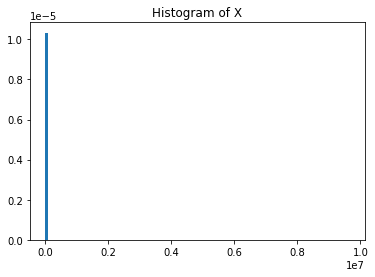

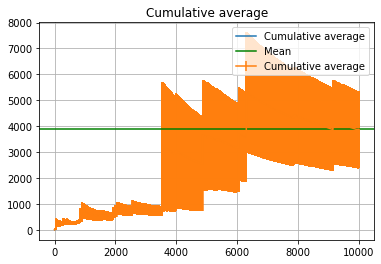

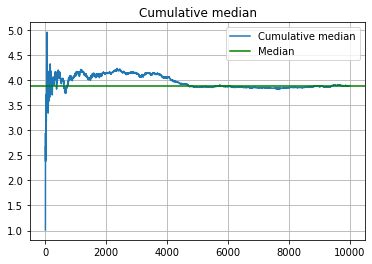

In [53]:
pareto_cum_avg_df, pareto_cum_sem, pareto_cum_med_df = calculate_cumulative_stats(P)

## Lognormal Distribution

In [54]:
mu, sigma = 0, 4

# lognormal

# sample from lognormal distribution
L = np.random.lognormal(mu, sigma, N)

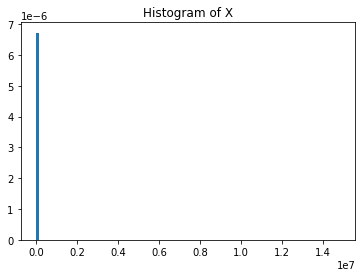

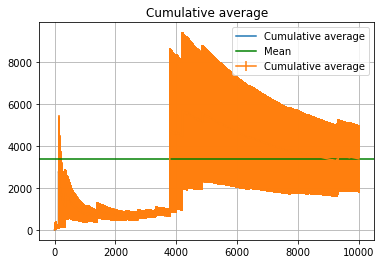

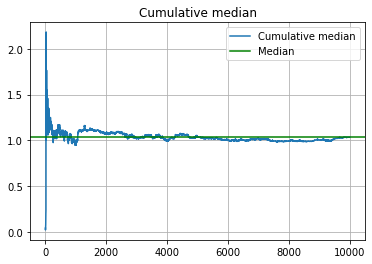

In [55]:
lognorm_cum_avg_df, lognorm_cum_sem, lognorm_cum_med_df = calculate_cumulative_stats(L)

## Citation distribution

In [56]:
# First we get the all the citation counts for all the papers from 2009
citation_counts = paper_df[paper_df["year"] == 2009]["citationCount"].values

shape of citation_counts: (1030,)
shape of citations_counts_sample: (10000,)


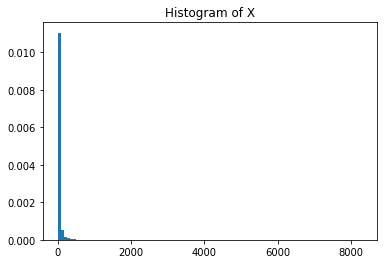

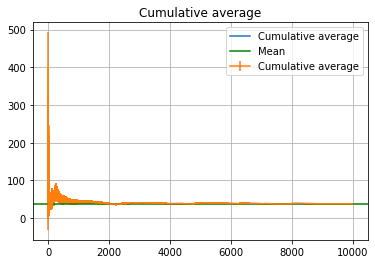

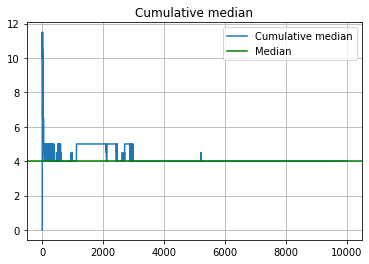

In [57]:
print(f"shape of citation_counts: {citation_counts.shape}")

# we only have 1000 papers from 2009 so we will instead sample from the whole dataframe


C = paper_df["citationCount"].sample(n=N).values

print(f"shape of citations_counts_sample: {C.shape}")



C_cum_avg_df, C_cum_sem, C_cum_med_df = calculate_cumulative_stats(C)



When we look at the many different plots we notice a common trend between the pareto, lognormal and citation distribution. This is they are highly influenced by outliers.

All 3 distribution plots show that they spike at one value, for the pareto distribution this is because the mean of the distribution for alpha less than 0 is $\inf$. If we inspect the actual mean of the 10000 samples we find that the mean if very different each time we run the code, where most samples are maybe in the range 0-100 while some are ridiciously high in the order of $10^8$ This makes sense as the pareto distribution is known as the 80-20% distribution, where 20% of the sample is responsible for 80% of the outcomes, so in this case, 20% of the 10000 samples are responsible for 80% of the total sum


If we look at the cumulative average for the different distributions we see even though the error is wildly different for the different distributions, they all seem to converge around the sample as we would expect. This is due the the law of long run probabilities / law or large numbers. As the sample size increases we would expect the sample mean to converge towards the actual mean


<hr>

Quite interesting is the difference between the cumulative average and the cumulative median, in most of the cases i would actually say the cumulative median is better as the errors seem to be quite a bit lower


I think the main takeaway from this exercise is generally we want to have as big a sample size as we can. In the real world this would mean to have as much data as possible. And we actually also see signs of this in the real world, in big companies that live on gathering and selling data, such as facebook, google etc. Pretty much any service on the internet that is offered free of charge it is because they are mining data and selling it, because it is so valuable
